# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

In [126]:
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [127]:
QUOTE_DATE = '2024-10-31'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'

raw_data = pd.read_excel(filepath_rawdata,sheet_name='quotes')
sel_quotes = pd.read_excel(filepath_rawdata,sheet_name='selected quotes')

sel_quotes.sort_values('maturity date',inplace=True)
raw_data.sort_values('maturity date',inplace=True)

sel_quotes.set_index('KYTREASNO',inplace=True)
raw_data.set_index('KYTREASNO',inplace=True)

In [128]:
sel_quotes = sel_quotes[~sel_quotes['type'].isin(['TIPS note', 'TIPS bond'])]
raw_data = raw_data[~raw_data['type'].isin(['TIPS note', 'TIPS bond'])]

***

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [129]:
def calc_cashflows(quote_data, filter_maturity_dates=False):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['maturity date'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'quote date'],quote_data.loc[i,'maturity date'])
        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'cpn rate']/2
        CF.loc[i,quote_data.loc[i,'maturity date']] += 100

    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)        
    return CF

In [130]:
CF = calc_cashflows(sel_quotes)

In [131]:
display(CF)

,2025-04-30,2025-10-30,2025-10-31,2026-04-30,2026-10-30,2026-10-31,2027-04-30,2027-10-30,2027-10-31,2028-04-30,...,2028-10-31,2029-04-30,2029-10-30,2029-10-31,2030-04-30,2030-10-30,2030-10-31,2031-04-30,2031-10-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208042,101.9375,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,...,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
208129,2.5000,2.5000,100,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,...,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
208213,2.4375,2.4375,0,102.4375,0.0000,0,0.0000,0.0000,0,0.0000,...,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
208302,2.0625,2.0625,0,2.0625,2.0625,100,0.0000,0.0000,0,0.0000,...,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
207875,1.3750,1.3750,0,1.3750,1.3750,0,101.3750,0.0000,0,0.0000,...,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
207960,2.0625,2.0625,0,2.0625,2.0625,0,2.0625,2.0625,100,0.0000,...,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
208044,1.7500,1.7500,0,1.7500,1.7500,0,1.7500,1.7500,0,101.7500,...,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
208132,2.4375,2.4375,0,2.4375,2.4375,0,2.4375,2.4375,0,2.4375,...,100,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
208216,2.3125,2.3125,0,2.3125,2.3125,0,2.3125,2.3125,0,2.3125,...,0,102.3125,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [132]:
def estimate_spot_discount_factors(prices, cashflows):
    if not isinstance(cashflows, pd.DataFrame):
        raise ValueError("cashflows must be a pandas DataFrame.")
    if not isinstance(prices, pd.Series):
        raise ValueError("prices must be a pandas Series.")
    
    try:
        z, _, _, _ = np.linalg.lstsq(cashflows.values, prices.values, rcond=None)
    except np.linalg.LinAlgError as e:
        raise ValueError(f"Linear system could not be solved: {e}")
    discount_factors = pd.Series(z.flatten(), index=cashflows.columns, name="Spot Discount Factors")   
    return discount_factors.to_frame()


spot_discount_factors = estimate_spot_discount_factors(sel_quotes['price'], CF)
spot_discount_factors

,Spot Discount Factors
2025-04-30,0.978220
2025-10-30,0.235306
2025-10-31,0.976173
2026-04-30,0.956557
2026-10-30,0.192726
2026-10-31,0.950642
2027-04-30,0.922483
2027-10-30,0.162815
2027-10-31,0.928922
2028-04-30,0.903073


### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

In [89]:
semiannual_discount_rates = compound_rate(spot_discount_factors, 2, None)  # Semiannual compounding
continuous_discount_rates = compound_rate(spot_discount_factors, None, 1)  # Continuous compounding

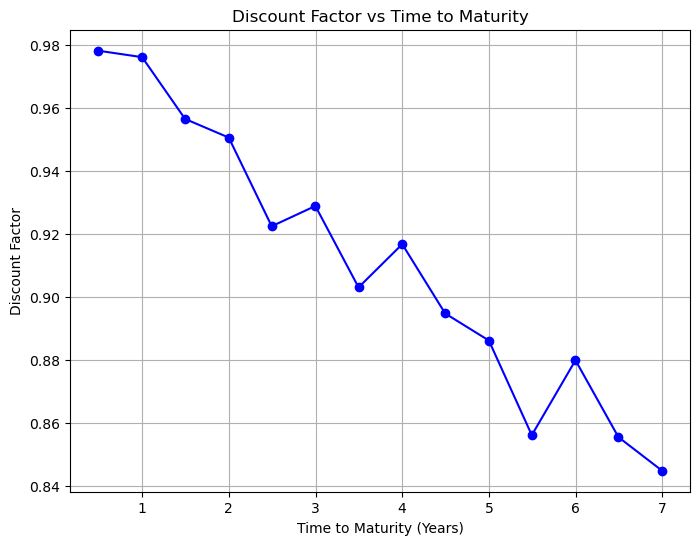

In [91]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(sel_quotes['ttm'], spot_discount_factors[spot_discount_factors.index.isin(sel_quotes['maturity date'])]['Spot Discount Factors'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Discount Factor')
plt.title('Discount Factor vs Time to Maturity')
plt.grid(True)

# Show the plot
plt.show()

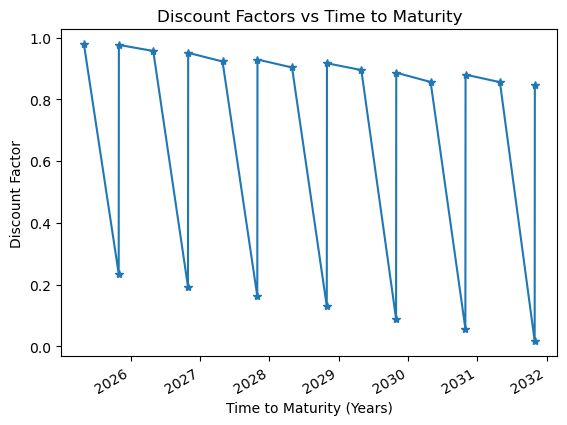

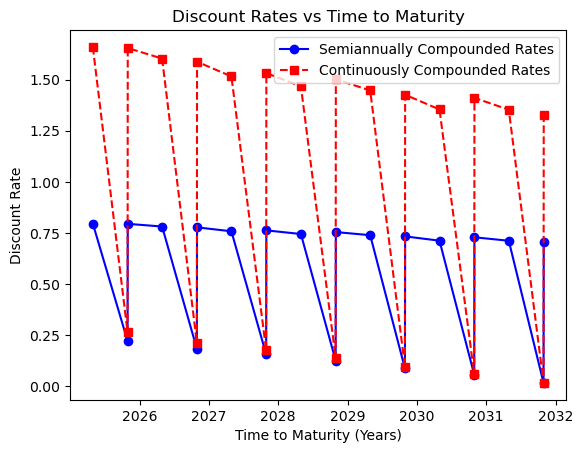

In [23]:
ax = spot_discount_factors.plot(
    linestyle='-', marker='*', 
    xlabel='Time to Maturity (Years)', ylabel='Discount Factor', 
    title='Discount Factors vs Time to Maturity'
)
plt.show()

# Plot 2: Semiannually and Continuously Compounded Discount Rates
fig, ax = plt.subplots()
ax.plot(spot_discount_factors.index, semiannual_discount_rates, label='Semiannually Compounded Rates', linestyle='-', marker='o', color='b')
ax.plot(spot_discount_factors.index, continuous_discount_rates, label='Continuously Compounded Rates', linestyle='--', marker='s', color='r')
ax.set_xlabel('Time to Maturity (Years)')
ax.set_ylabel('Discount Rate')
ax.set_title('Discount Rates vs Time to Maturity')
ax.legend()
plt.show()


### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [133]:
raw_data["ytm"] = pd.to_numeric(raw_data["ytm"], errors="coerce")
raw_data = raw_data.dropna(subset=["ytm"])

In [134]:
CF = calc_cashflows(raw_data)
prices = raw_data['price'][CF.index]

In [135]:
CF.head()

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0,100,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0,0,100,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0,0,0,100,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,0,0,0,0,103.75,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
CF.tail()

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208107,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.000,0.0000,0.000
208149,0,0,0,0,2.3750,0,0,0,0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000,0.000
208178,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125,0.0000,0.000
208233,0,0,0,0,2.3125,0,0,0,0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125,0.000
208279,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.125,0.0000,102.125


In [137]:
total_cashflow_per_date = CF.sum(axis=0)
max_cashflow_date = total_cashflow_per_date.idxmax()
max_cashflow_value = total_cashflow_per_date.max()

issues_per_date = (CF > 0).sum(axis=0)
max_issues_date = issues_per_date.idxmax()
max_issues_count = issues_per_date.max()

print(f"Date with the most cashflow: {max_cashflow_date} (Cashflow: {max_cashflow_value})")
print(f"Date with the most issues paying cashflow: {max_issues_date} (Issues: {max_issues_count})")

Date with the most cashflow: 2025-02-15 00:00:00 (Cashflow: 435.25)
Date with the most issues paying cashflow: 2025-02-15 00:00:00 (Issues: 80)


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [138]:
t_check = raw_data['quote date'].values[0]
if raw_data['quote date'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

In [139]:
def filter_treasuries(data, t_date=None):
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['quote date'].values[-1]
    
    outdata = outdata[outdata['quote date']==t_date]        
    return outdata

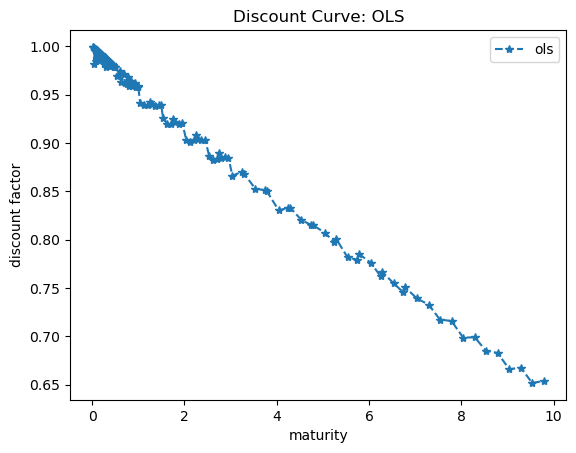

In [142]:
MODEL = bootstrap
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

data = filter_treasuries(raw_data, t_date=t_current)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = raw_data['price'][CF.index]
params_OLS = estimate_rate_curve(MODEL,CF,t_current,prices)

label = 'no non-maturity dates'
CFset = {}
CFset[label] = CF

disc_ols = pd.DataFrame({'maturity':params_OLS[0], 'ols': params_OLS[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

In [143]:
CF.head()

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15,2033-08-15,2033-11-15,2034-02-15,2034-05-15,2034-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0,100,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0,0,100,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0,0,0,100,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,0,0,0,0,103.75,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
CF.tail()

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15,2033-08-15,2033-11-15,2034-02-15,2034-05-15,2034-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208105,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.9375,0.0000,1.9375,0.0000,101.9375,0.0000,0.0000,0.0000,0.0000
208147,0,0,0,0,2.2500,0,0,0,0,0.0,...,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.0000
208177,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,102.0000,0.0000,0.0000
208231,0,0,0,0,2.1875,0,0,0,0,0.0,...,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,102.1875,0.0000
208277,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,101.9375


### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

***

In [146]:
maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['ols'] = bootstrap(params_OLS,maturity_grid)

In [148]:
prices = raw_data['price'][CF.index]

x0 = np.ones((4,))/10
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,prices,x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns

/Users/aparnaambarapu/Documents/UChicago/Winter_2024/fixed_income/finm-fixedincome-2025/homework/../cmds/treasury_cmds.py:214: RuntimeWarning: overflow encountered in exp
  discount = np.exp(-intrate * maturity)
/Users/aparnaambarapu/Documents/UChicago/Winter_2024/fixed_income/finm-fixedincome-2025/homework/../cmds/treasury_cmds.py:214: RuntimeWarning: overflow encountered in exp
  discount = np.exp(-intrate * maturity)


,theta 0,theta 1,theta 2,lambda_1
Nelson-Siegel,0.020425,0.097648,0.097698,0.095517


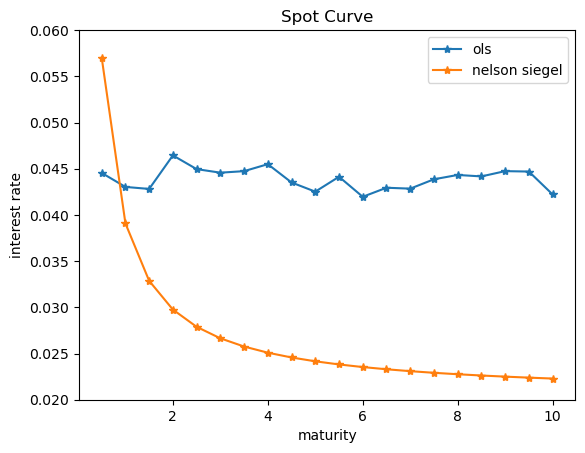

In [150]:
inc = .5

maturity_list = get_maturity_delta(list(CFset.values())[-1].columns,t_current=t_current)
maturity_grid = np.arange(inc,maturity_list.max()+.5,inc)
curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(0,1.1*curves.max().max()*1.1))

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.ylim(.02,.06)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



In [26]:
filepath_rawdata = f'../data/yields.xlsx'
yields = pd.read_excel(filepath_rawdata,sheet_name='yields')
yields.set_index('caldt',inplace=True)
yields.head()

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018


### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [27]:
shapes = pd.DataFrame(yields.mean(axis=1),columns=['level'])
shapes['slope'] = yields[30]-yields[1]
shapes['curvature'] = -yields[1] + 2 * yields[10] - yields[30]

In [33]:
shapes.corr()

,level,slope,curvature
level,1.000000,-0.375967,-0.169325
slope,-0.375967,1.000000,0.647671
curvature,-0.169325,0.647671,1.000000


In [32]:
shapes.describe()

,level,slope,curvature
count,15723.000000,15723.000000,15723.000000
mean,5.475250,1.109788,0.671817
std,2.914725,1.480255,0.971945
min,0.487603,-3.490292,-5.426753
25%,3.447801,-0.012832,0.096639
50%,5.193728,1.010982,0.623795
75%,7.166966,2.124039,1.335932
max,15.259628,4.358273,3.283792


### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [76]:
pca = PCA()
# scaler = StandardScaler()
# data = scaler.fit_transform(yields)
# #pca.fit(yields)
p_comps = pca.fit_transform(yields)
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_,columns=['Variance explained']).T
pca_var_explained.columns = list(np.arange(1,8,1))
pca_var_explained.style.format('{:.2%}'.format)

,1,2,3,4,5,6,7
Variance explained,97.07%,2.53%,0.29%,0.05%,0.04%,0.02%,0.01%


In [77]:
loadings = pca.components_
print(f"Principal Component 1 Loadings:")
print(loadings[0])
print(f"Principal Component 2 Loadings:")
print(loadings[1])

Principal Component 1 Loadings:
[0.41146434 0.41105437 0.39278425 0.37835346 0.36338009 0.34406865
 0.33744966]
Principal Component 2 Loadings:
[ 0.59100632  0.39929796  0.04680591 -0.08743853 -0.20267351 -0.43885647
 -0.49775981]


### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

In [78]:
pca_1 = yields @ pca_wts.iloc[0,:].T
pca_2 =  yields @ pca_wts.iloc[1,:].T

print(f"Correlation between ad-hoc level Factor and PCA-1: {np.corrcoef(shapes['level'], pca_1)[0, 1]:.4f}")
print(f"Correlation between slope Factor and PCA-2: {np.corrcoef(shapes['slope'], pca_2)[0, 1]:.4f}")

Correlation between ad-hoc level Factor and PCA-1: 0.9999
Correlation between slope Factor and PCA-2: -0.9178
